# Challenge 3: Artificial Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from time import time

torch.manual_seed(0)

## 1. Data exploration

In [2]:
BATCH_SIZE = 64

data_transforms = transforms.ToTensor()

## TRAIN set
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
print(len(trainset))

## TEST set
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
print(len(testset))

60000
10000


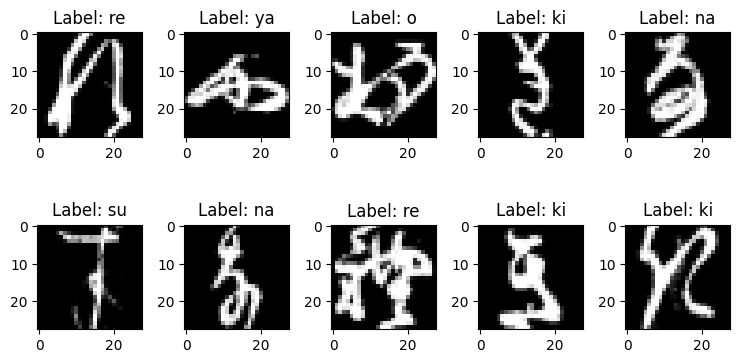

Classes: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


In [3]:
num_row = 2
num_col = 5

classes = trainset.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(classes[trainset.targets[i]]))
plt.tight_layout()
plt.show()

print(f'Classes: {classes}')

In [4]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


## Model building

#### FULLY CONNECTED

In [5]:
class FullyConnected_1(nn.Module):
    def __init__(self):
        super(FullyConnected_1, self).__init__()

        self.l1 = nn.Linear(28 * 28, 32 * 26 * 26)  # Input size: 28*28 (dimensione immagine KMNIST)
        self.l2 = nn.Linear(32 * 26 * 26, 128)
        self.l3 = nn.Linear(128, 10)


    def forward(self, x):
        # Flatten: BSx1x28x28 => BSx(28*28)
        x = x.view(x.size(0), -1)

        # BSx(28*28) => BSx128
        x = F.relu(self.l1(x))

        # BSx128 => BSx64
        x = F.relu(self.l2(x))

        # BSx64 => BSx10
        logits = self.l3(x)

        # Softmax computation
        out = F.softmax(logits, dim=1)

        return out

#### CONVOLUTIONAL

1 hidden layer

In [6]:
class Convolutional_1(nn.Module):
    def __init__(self):
        super(Convolutional_1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)   # 28 - kernel_size +1 = 24
        # max-pooling 2x2: 24 / 2 = 12
        self.l1 = nn.Linear(32 * 12 * 12, 128)
        self.l2 = nn.Linear(128, 10)


    def forward(self, x):

        x = self.conv1(x)               # Convolution: BSx1x28x28 => BSx32x24x24
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = x.flatten(start_dim = 1)    # flatten => BS x 21632

        x = self.l1(x)                  # Linear: BSx(32*26*26) => BSx128
        x = F.relu(x)

        logits = self.l2(x)             # Linear: BSx128 => BSx10

        # Softmax computation: ogni neurone in uscita avra un label assegnato; softmax indica la probabilita che appartenga effettivamente a quella classe
        out = F.softmax(logits, dim=1)

        return out

3 hidden layers

In [7]:
class Convolutional_3(nn.Module):
    def __init__(self):
        super(Convolutional_3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)       # 28 - kernel_size +1 = 24
        # max-pooling 2x2: 24 / 2 = 12
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)     # 12 - kernel_size +1 = 10
        # max-pooling 2x2: 10 / 2 = 5
        self.l1 = nn.Linear(128 * 5 * 5, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, 10)


    def forward(self, x):

        x = self.conv1(x)               # Convolution: BSx1x28x28 => BSx32x24x24
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = self.conv2(x)
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = x.flatten(start_dim = 1)    # flatten => BS x 21632

        x = self.l1(x)                  # Linear: BSx(32*26*26) => BSx128
        x = F.relu(x)

        x = self.l2(x)                  # Linear: BSx(32*26*26) => BSx128
        x = F.relu(x)

        logits = self.l3(x)             # Linear: BSx128 => BSx10

        # Softmax computation: ogni neurone in uscita avra un label assegnato; softmax indica la probabilita che appartenga effettivamente a quella classe
        out = F.softmax(logits, dim=1)

        return out

#### Training cycle

In [8]:
def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()


def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer, lr):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f'Using device: {device}' if device=='cpu' else f'Using device: {device} ({torch.cuda.get_device_name()})')

    print(f'Training model: {model.__class__.__name__}, with parameters\n\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')

    # Rich mac user
    # device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model = model.to(device)

    losses = []
    accs = []

    norms = []

    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)


        losses.append(train_running_loss / i)
        accs.append(train_acc/i)

        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"Epoch: [{epoch+1}/{num_epochs}] | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")

    print('\n')
    return losses, accs, norms, device

In [9]:
models = [[FullyConnected_1(), FullyConnected_1()], [Convolutional_1(), Convolutional_1()], [Convolutional_3(), Convolutional_3()]]
num_epochs = 7
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

losses = []
accuracies = []
weight_norms = []
optimizer_names = ['SGD', 'Adam']

for model in models:

    loss_sgd, acc_sgd, W_sgd, device = train_model(model[0], num_epochs, trainloader, criterion, torch.optim.SGD(model[0].parameters(), lr=learning_rate), learning_rate)
    loss_adam, acc_adam, W_adam, _ = train_model(model[1], num_epochs, trainloader, criterion, torch.optim.Adam(model[1].parameters(), lr=learning_rate), learning_rate)

    losses.extend([loss_sgd, loss_adam])
    accuracies.extend([acc_sgd, acc_adam])
    weight_norms.extend([W_sgd, W_adam])


Using device: cuda (AMD Radeon RX 7800 XT)
Training model: FullyConnected_1, with parameters
	Epochs: 7
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: SGD

Epoch: 1 | Loss: 2.3025 | Train Accuracy: 21.9934 | Time: 5.76
Epoch: 2 | Loss: 2.2959 | Train Accuracy: 37.8335 | Time: 5.25
Epoch: 3 | Loss: 2.2866 | Train Accuracy: 45.0173 | Time: 5.32
Epoch: 4 | Loss: 2.2733 | Train Accuracy: 45.0790 | Time: 5.32
Epoch: 5 | Loss: 2.2537 | Train Accuracy: 42.6277 | Time: 5.24
Epoch: 6 | Loss: 2.2248 | Train Accuracy: 39.5611 | Time: 5.29
Epoch: 7 | Loss: 2.1883 | Train Accuracy: 38.8657 | Time: 5.25


Using device: cuda (AMD Radeon RX 7800 XT)
Training model: FullyConnected_1, with parameters
	Epochs: 7
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Epoch: 1 | Loss: 1.6951 | Train Accuracy: 76.7726 | Time: 7.90
Epoch: 2 | Loss: 1.5943 | Train Accuracy: 86.9114 | Time: 7.86
Epoch: 3 | Loss: 1.5811 | Train Accuracy: 88.2170 | Time: 7.87
Epoch: 4 | 

In [10]:
print(device)

cuda


## Tables
3. Summarise your results in a table and comment on them in the report.

In [11]:
num_models = len(models)                   # number of models: in this case, 3 (FullyConnected_1, Convolutional_1, Convolutional_3)
num_optimizers = len(optimizer_names)      # number of optimizers: in this case, 2 (SGD and Adam)
num_rows = num_epochs * num_models * num_optimizers

table = pd.DataFrame({'Model' : [models[i][0].__class__.__name__ for i in range(num_models) for j in range(num_epochs*num_optimizers)],
         'Optimizer' : [optimizer_names[i] for k in range(num_models) for i in range(num_optimizers) for j in range(num_epochs)],
         'Epoch': [i % (num_epochs) + 1 for i in range(num_rows)],
         'Loss': [losses[i][j] for i in range(num_models*num_optimizers) for j in range(num_epochs)],
         'Accuracy (train)': [accuracies[i][j] for i in range(num_models*num_optimizers) for j in range(num_epochs)],
        })

separator = pd.DataFrame({'Model' : ['---'],
         'Optimizer' : ['---'],
         'Epoch': ['---'],
         'Loss': ['---'],
         'Accuracy (train)': ['---'],
        })

for i in range(num_optimizers*num_epochs, num_rows, num_optimizers*num_epochs+1):
        table = pd.concat([table.iloc[:i], separator, table.iloc[i:]]).reset_index(drop=True)

table

,Model,Optimizer,Epoch,Loss,Accuracy (train)
0,FullyConnected_1,SGD,1,2.302549,21.993396
1,FullyConnected_1,SGD,2,2.295898,37.833511
2,FullyConnected_1,SGD,3,2.286569,45.017343
3,FullyConnected_1,SGD,4,2.273269,45.079042
4,FullyConnected_1,SGD,5,2.253709,42.627735
5,FullyConnected_1,SGD,6,2.224811,39.561099
6,FullyConnected_1,SGD,7,2.188276,38.865728
7,FullyConnected_1,Adam,1,1.695076,76.772612
8,FullyConnected_1,Adam,2,1.59426,86.911353
9,FullyConnected_1,Adam,3,1.581134,88.217049


## Plotting
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [12]:
'''# Number of times the whole (training) dataset is used for training
model = Convolutional_3()
num_epochs = 2
learning_rate = 0.01

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


_, acc_adam, W_adam, device = train_model(model, num_epochs, trainloader, criterion, optimizer, learning_rate)'''

'# Number of times the whole (training) dataset is used for training\nmodel = Convolutional_3()\nnum_epochs = 2\nlearning_rate = 0.01\n\ncriterion = nn.CrossEntropyLoss() # loss function\noptimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)\n\n\n_, acc_adam, W_adam, device = train_model(model, num_epochs, trainloader, criterion, optimizer, learning_rate)'

In [13]:
'''test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")'''

'test_acc = 0.0\nfor i, (images, labels) in enumerate(testloader, 0):\n    images = images.to(device)\n    labels = labels.to(device)\n    outputs = model(images)\n    test_acc += get_accuracy(outputs, labels)\n\nprint(f"Test Accuracy: {test_acc/i:.4f}")'

In [14]:
'''# Number of times the whole (training) dataset is used for training
model = Convolutional_3()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


_, acc_adam, W_adam, device = train_model(model, num_epochs, trainloader, criterion, optimizer, learning_rate)'''

'# Number of times the whole (training) dataset is used for training\nmodel = Convolutional_3()\noptimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\n\n\n_, acc_adam, W_adam, device = train_model(model, num_epochs, trainloader, criterion, optimizer, learning_rate)'

In [15]:
'''test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")'''

'test_acc = 0.0\nfor i, (images, labels) in enumerate(testloader, 0):\n    images = images.to(device)\n    labels = labels.to(device)\n    outputs = model(images)\n    test_acc += get_accuracy(outputs, labels)\n\nprint(f"Test Accuracy: {test_acc/i:.4f}")'

In [16]:
'''model = FullyConnected()
num_epochs = 5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

_, acc_SGD, W_SGD = train_model(model, num_epochs, trainloader, criterion, optimizer)'''

'model = FullyConnected()\nnum_epochs = 5\nlearning_rate = 0.001\n\ncriterion = nn.CrossEntropyLoss() # loss function\noptimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)\n\n_, acc_SGD, W_SGD = train_model(model, num_epochs, trainloader, criterion, optimizer)'

In [17]:
'''test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i:.4f}")'''

'test_acc = 0.0\nfor i, (images, labels) in enumerate(testloader, 0):\n    images = images.to(device)\n    labels = labels.to(device)\n    outputs = model(images)\n    test_acc += get_batch_accuracy(outputs, labels)\n\nprint(f"Test Accuracy: {test_acc/i:.4f}")'